In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature
# plot
import cmocean as ccm

In [2]:
from dask.distributed import Client
c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35183,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:43787,Total threads: 2
Dashboard: http://127.0.0.1:38375/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46789,


In [4]:
%%time
chunk_size = {"x":500,"y":500}

diridat = '/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-IMHOTEP.'
daUGAI = xr.open_mfdataset(diridat+'GAI-S/1y/????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridU.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)
daUAI = xr.open_mfdataset(diridat+'AI-S/1y/????/eORCA025.L75-IMHOTEP.AI_y*.1y_gridU.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)
daUS = xr.open_mfdataset(diridat+'S-S/1y/????/eORCA025.L75-IMHOTEP.S_y*.1y_gridU.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)

tauxGAI = daUGAI.sozotaux#.where(nav_lat>=60, drop=True)
tauxAI = daUAI.sozotaux#.where(nav_lat>=60, drop=True)
tauxS = daUS.sozotaux#.where(nav_lat>=60, drop=True)

daVGAI = xr.open_mfdataset(diridat+'GAI-S/1y/????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridV.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)
daVAI = xr.open_mfdataset(diridat+'AI-S/1y/????/eORCA025.L75-IMHOTEP.AI_y*.1y_gridV.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)
daVS = xr.open_mfdataset(diridat+'S-S/1y/????/eORCA025.L75-IMHOTEP.S_y*.1y_gridV.nc', chunks=chunk_size, parallel=True) #, decode_times=False).assign_coords(time_counter=time)

tauyGAI = daVGAI.sometauy#.where(nav_lat>=60, drop=True)
tauyAI = daVAI.sometauy#.where(nav_lat>=60, drop=True)
tauyS = daVS.sometauy# .where(nav_lat>=60, drop=True)

CPU times: user 1.94 s, sys: 132 ms, total: 2.07 s
Wall time: 6.53 s


In [26]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)
nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat

In [6]:
curlGAI = (tauyGAI.diff(dim='x') / e1t.isel(x=np.arange(1,1442)) ).isel(y=np.arange(1,1207)) - \
((tauxGAI.diff(dim='y')/ e2t.isel(y=np.arange(1,1207)) ).isel(x=np.arange(1,1442)) )

In [7]:
curlGAI

<xarray.DataArray (time_counter: 39, y: 1206, x: 1441)>
dask.array<sub, shape=(39, 1206, 1441), dtype=float64, chunksize=(1, 499, 499), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-07-02 ... 2018-07-02T12:...
Dimensions without coordinates: y, x

# wind curl mean

In [8]:
# full time period
y1= "1980"
y2= "2018"

In [14]:
curlGAImean = curlGAI.mean('time_counter')

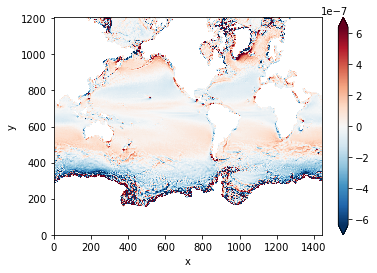

In [13]:
curlGAImean.plot(robust=True)

#### plotting the map

In [15]:
#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [23]:
cmap = cm.Spectral_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -5e-7
incr = 5e-8
lmax = lmin*(-1)+incr
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)

In [24]:
bounds

array([-5.0e-07, -4.5e-07, -4.0e-07, -3.5e-07, -3.0e-07, -2.5e-07,
       -2.0e-07, -1.5e-07, -1.0e-07, -5.0e-08,  0.0e+00,  5.0e-08,
        1.0e-07,  1.5e-07,  2.0e-07,  2.5e-07,  3.0e-07,  3.5e-07,
        4.0e-07,  4.5e-07,  5.0e-07,  5.5e-07])

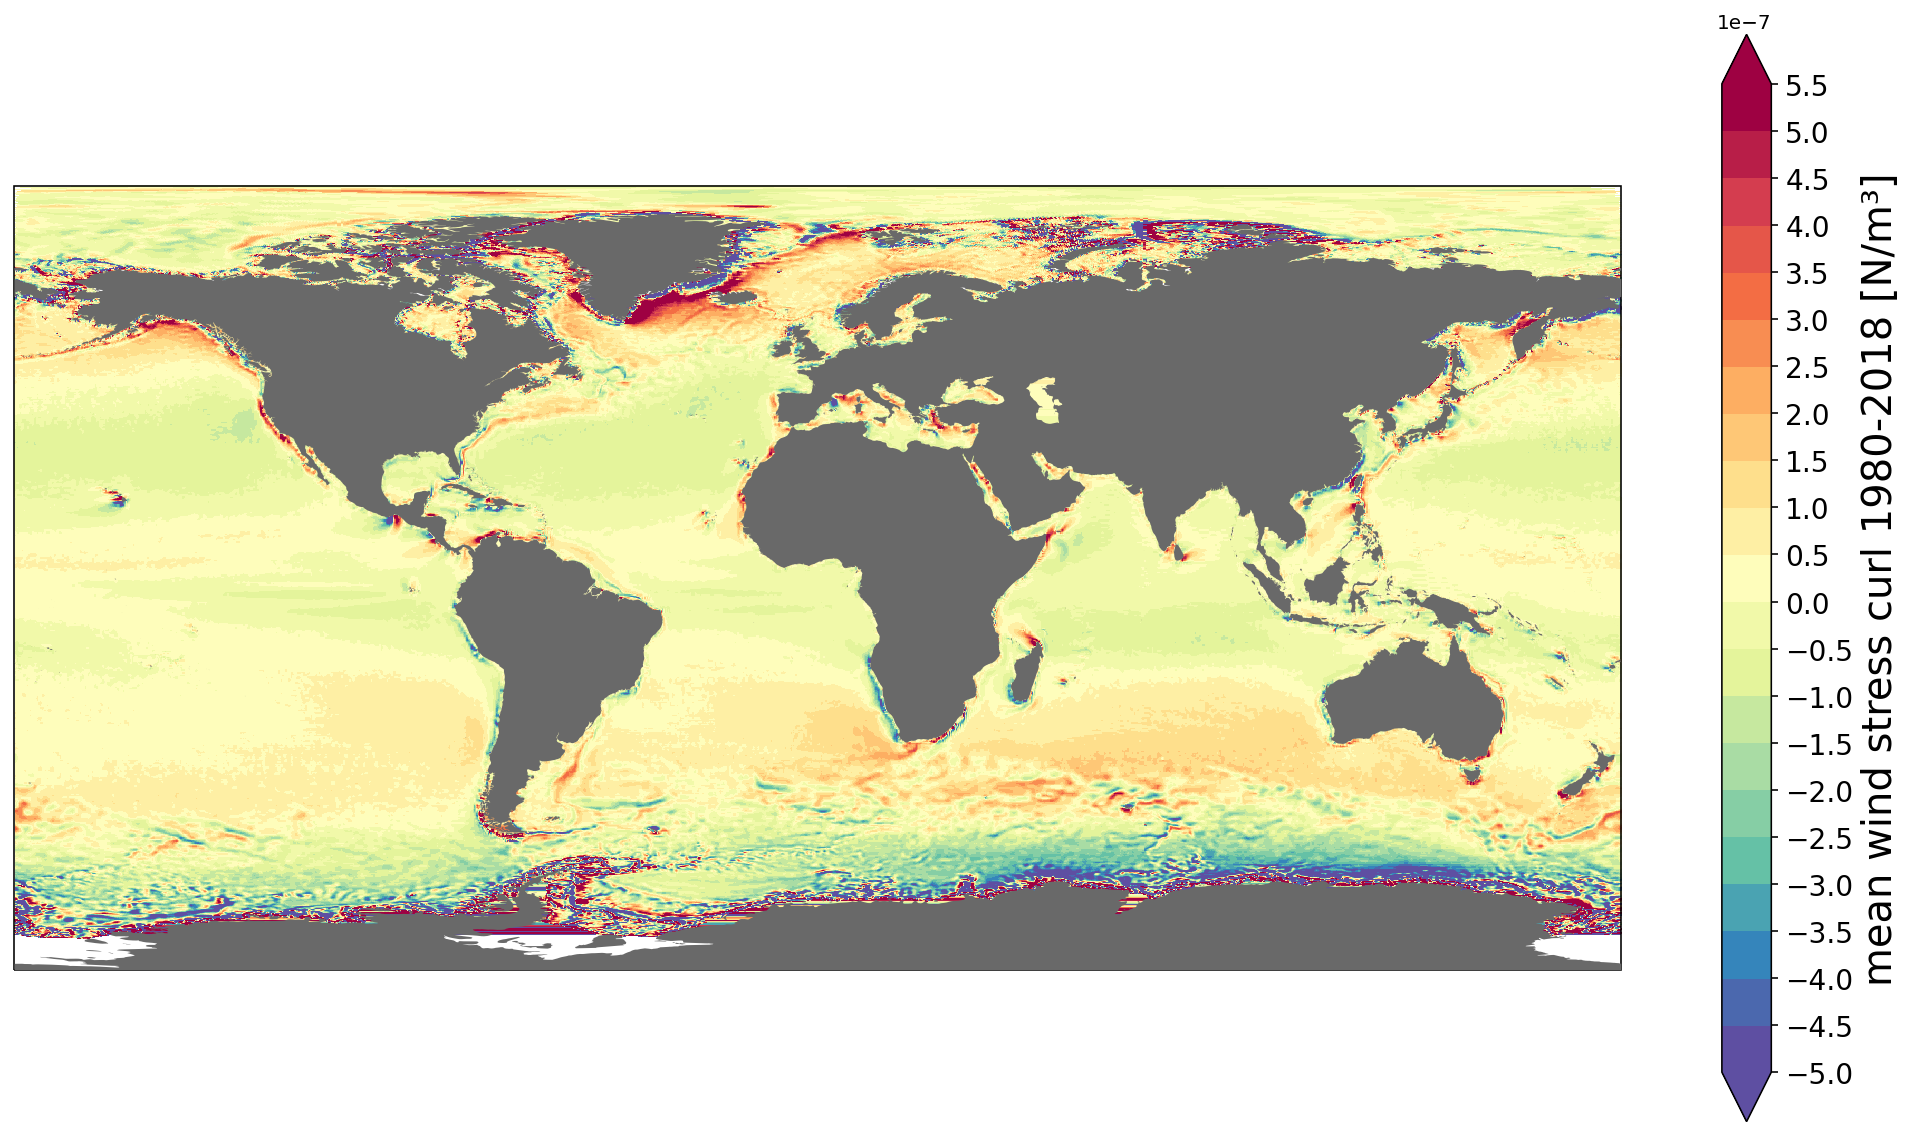

<Figure size 432x288 with 0 Axes>

In [27]:
#========= CREATE FIGURE
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# RUN to PLOT
# data2plot = r_matrix2plot.isel(lag=i).where(tmask!=0,0).squeeze()
# yr, mm = dates(S_GR_short.isel(time_counter=t))
# tlabel= "Correlation coefficient for time lag = "+str(r_matrix2plot.lag[i].values)+" years" #"whole column S_GR integral for "+str(yr)+"-"+f"{mm:02d}" + r" [10$-3$]"
# namo  ="GAI_AI_corr_map_SSH_S_GR_lag"+str(r_matrix2plot.lag[i].values)+"y.png"
# print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.PlateCarree())

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlGAImean, shading='flat',cmap = mycm,transform=trdata, norm=norm)
cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'mean wind stress curl '+y1+'-'+y2+' [N/m³]', fontsize=20)

#========= coastlines and gridlines
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
# gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
# label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
# gl.xlabel_style = label_style; gl.ylabel_style = label_style


# plt.title(tlabel,fontsize=24)
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)
plt.clf()